In [240]:
import os
import re
import json
import pickle 
from pathlib import Path
import yaml

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import scipy
import skimage
import pandas as pd
import torch
import torchvision
import torchvision.transforms.functional as TF
import tifffile
from sklearn.metrics import adjusted_rand_score
from scipy.cluster.hierarchy import dendrogram
from einops import rearrange, repeat

In [241]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [242]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [243]:
%autoreload 2

In [244]:
import mushroom.utils as utils
import mushroom.visualization.utils as vis_utils
import mushroom.data.datasets as datasets
import mushroom.data.visium as visium
import mushroom.data.xenium as xenium
import mushroom.data.multiplex as multiplex
import mushroom.data.he as he
import mushroom.registration.bigwarp as bigwarp
import mushroom.visualization.helpers as helpers
from mushroom.mushroom import Mushroom

In [245]:
project_dir = Path('/data/estorrs/mushroom/data/projects/submission_v1')
output_dir = project_dir / 'analysis' / 'region_characterization'
output_dir.mkdir(parents=True, exist_ok=True)

In [246]:
source_root = '/diskmnt/Projects/Users/estorrs/mushroom/data'
target_root = '/data/estorrs/mushroom/data'

def alter_filesystem(config, source_root, target_root):
    for entry in config['sections']:
        for mapping in entry['data']:
            mapping['filepath'] = mapping['filepath'].replace(source_root, target_root)
    
    if 'trainer_kwargs' in config and config['trainer_kwargs']['data_mask'] is not None:
        config['trainer_kwargs']['data_mask'] = config['trainer_kwargs']['data_mask'].replace(source_root, target_root)
        
    return config

In [377]:
case_order = [
    # 'HT206B1',
    # 'HT268B1',
    # 'HT339B2-H1',
    # 'HT397B1',
    # 'HT565B1-H2',
    # 'HT704B1',
    # 'HT891Z1',
    # 'HT913Z1',
    # 'S18-5591-C8',
    'S18-9906',
]

In [248]:
mapping = {
    'brca': [
        'HT206B1',
        'HT268B1',
        'HT339B2-H1',
        'HT397B1',
        'HT565B1-H2',
        'HT704B1',
    ],
    'prad': [
        'HT891Z1',
        'HT913Z1',
        'S18-5591-C8',
        'S18-9906'
    ],
}
case_to_disease = {
    v:k for k, vs in mapping.items() for v in vs
}

In [249]:
fps = sorted(utils.listfiles(project_dir, regex=r'mushroom_50res/config.yaml$'))
fps = [fp for fp in fps if fp.split('/')[-3] in case_order]
fps

['/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT268B1/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT339B2-H1/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT565B1-H2/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT891Z1/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT913Z1/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/S18-5591-C8/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/S18-9906/mushroom_50res/config.yaml']

In [250]:
case_to_config = {fp.split('/')[-3]:yaml.safe_load(open(fp)) for fp in fps}
case_to_config.keys()

dict_keys(['HT206B1', 'HT268B1', 'HT339B2-H1', 'HT397B1', 'HT565B1-H2', 'HT704B1', 'HT891Z1', 'HT913Z1', 'S18-5591-C8', 'S18-9906'])

In [251]:
multiplex_mapping = {
    'keratin-5': 'ck5',
    'keratin-14': 'ck14',
}
pattern = r'[ -]?\(?[dD]\)?$'
def alter_name(x):
    x = re.sub(pattern, '', x)
    x = x.lower()
    x = x.replace(' ', '-')
    x = multiplex_mapping.get(x, x)
    return x

In [252]:
def generate_labeled_regions(x, cut=10, area=10, fill_holes=True):
    mask = x > cut

    if fill_holes:
        mask = scipy.ndimage.binary_fill_holes(mask)

    labeled = skimage.morphology.label(mask)

    props = skimage.measure.regionprops(labeled)
    count = 0
    for p in props:
        if p.area < area:
            labeled[labeled==p.label] = 0
            count += 1
    return labeled

def get_feature_df(labeled, img, channels, channel_info):
    annots = sorted(channel_info.keys())
    data = []
    columns =  channels + annots
    props = skimage.measure.regionprops(labeled, intensity_image=rearrange(img, 'c h w -> h w c'))
    for p in props:
        row = list(p.intensity_mean)
        r1, c1, r2, c2 = p.bbox
        for annot in annots:
            tile = annot_to_mask[annot][r1:r2, c1:c2]
            frac = np.count_nonzero(tile[p.image] > 0) / np.count_nonzero(p.image)
            row.append(frac)
        data.append(row)
    return pd.DataFrame(data=data, columns=columns, index=[p.label for p in props])

def get_feature_df_vishd(labeled, adata):
    data = []
    columns =  adata.var.index.to_list()
    ys, xs = adata.obs['y_location'].astype(int).to_list(), adata.obs['x_location'].astype(int).to_list()
    adata.obs['region'] = labeled[ys, xs]
    
    pool = [x for x in np.unique(labeled) if x]
    for l in pool:
        f = adata[adata.obs['region']==l]
        if f.shape[0]:
            means = np.asarray(f.X.mean(0))[0]
        else:
            means = [np.nan] * adata.shape[1]
        data.append(means)
    
    return pd.DataFrame(data=data, columns=columns, index=pool)

In [378]:
case_to_channel_info = {
    'HT206B1': {
        'xenium_0': {
            'epithelial': ('EPCAM', 1),
            'myoepithelial': ('ACTA2', 5),
        },
        'xenium_1': {
            'epithelial': ('EPCAM', 1),
            'myoepithelial': ('ACTA2', 5),
        },
        'multiplex_0': {
            'epithelial': ('pan-cytokeratin', 40),
            'myoepithelial': ('sma', 40),
        },
        'multiplex_1': {
            'epithelial': ('pan-cytokeratin', 40),
            'myoepithelial': ('sma', 40),
        },
        'cosmx_0': {
            'epithelial': ('KRT18', 15),
            'myoepithelial': ('ACTA2', 5),
        },
    },
    'HT704B1': {
        'xenium_0': {
            'epithelial': ('EPCAM', 1),
            'myoepithelial': ('KRT5', 5),
        },
        'cosmx_0': {
            'epithelial': ('KRT18', 15),
            'myoepithelial': ('KRT5', 5),
        },
        'multiplex_0': {
            'epithelial': ('pan-cytokeratin', 40),
            'myoepithelial': ('ck5', 40),
        },
        'vishd_0': {
            'epithelial': ('KRT18', 1),
            'myoepithelial': ('KRT5', 5),
        },
        'vishd_multpred': {
            'epithelial': ('pan-cytokeratin', 60),
        }
    },
    'HT397B1': {
        'multiplex_0': {
            'epithelial': ('pan-cytokeratin', 40),
            'myoepithelial': ('ck14', 20),
        },
        'multiplex_1': {
            'epithelial': ('pan-cytokeratin', 40),
            'myoepithelial': ('ck14', 20),
        },
        'multiplex_2': {
            'epithelial': ('pan-cytokeratin', 40),
            'myoepithelial': ('ck14', 20),
        }
    },
    'HT339B2-H1': {
        'multiplex_0': {
            'epithelial': ('pan-cytokeratin', 5),
            'myoepithelial': ('ck5', 40),
        }
    },
    'HT565B1-H2': {
        'multiplex_0': {
            'epithelial': ('pan-cytokeratin', 40),
            'myoepithelial': ('ck5', 40),
        }
    },
    'HT891Z1': {
        'xenium_0': {
            'epithelial': ('KRT18', 15),
            'myoepithelial': ('KRT5', 5),
        },
        'multiplex_0': {
            'epithelial': ('e-cadherin', 55),
            'myoepithelial': ('ck5', 40),
        },
        'vishd_0': {
            'epithelial': ('KRT18', 1),
            'myoepithelial': ('KRT5', 5),
        },
        'vishd_multpred': {
            'epithelial': ('e-cadherin', 60),
        },
        'cosmx_0': {
            'epithelial': ('KRT18', 1),
            'myoepithelial': ('KRT5', 5),
        }
    },
    'HT913Z1': {
        'xenium_0': {
            'epithelial': ('EPCAM', 1),
            'myoepithelial': ('TP63', 5),
        },
        'xenium_1': {
            'epithelial': ('KRT18', 15),
            'myoepithelial': ('KRT5', 5),
        },
        'multiplex_0': {
            'epithelial': ('e-cadherin', 100),
            'myoepithelial': ('ck5', 40),
        }
    },
    'S18-5591-C8': {
        'xenium_0': {
            'epithelial': ('KRT18', 5),
            'myoepithelial': ('KRT5', 5),
        },
        'multiplex_0': {
            'epithelial': ('e-cadherin', 3),
            'myoepithelial': ('ck5', 40),
        }
    },
    'S18-9906': {
        'xenium_0': {
            'epithelial': ('EPCAM', 1),
            'myoepithelial': ('KRT7', 5),
        },
        'multiplex_0': {
            'epithelial': ('e-cadherin', 20),
            'myoepithelial': ('ck5', 40),
        }
    },
    
        
}

In [379]:
def shrink_labels(labeled, distance=1):
    z = distance + 10
    new = labeled.copy()
    props = skimage.measure.regionprops(labeled)
    for p in props:
        r1, c1, r2, c2 = p.bbox
        r1 = max(0, r1 - z)
        c1 = max(0, c1 - z)
        r2 = min(r2 + z, labeled.shape[0])
        c2 = min(c2 + z, labeled.shape[1])
    
        labeled_tile = new[r1:r2, c1:c2]
    
        m = labeled_tile == p.label
        m2 = m.copy()
        for i in range(distance):
            m2 = skimage.morphology.binary_erosion(m2)
    
        new_tile = labeled_tile.copy()
        new_tile[m & ~m2] = 0
    
        new[r1:r2, c1:c2] = new_tile

    return new


    
    

In [369]:
# case = 'HT913Z1'
# imaris_dir = project_dir / case / 'imaris' / 'rois'
# config = yaml.safe_load(open(project_dir / case / 'registered' / 'metadata.yaml'))
# config = alter_filesystem(config, source_root, target_root)

# meta = json.load(open(imaris_dir / 'tiled' / 'metadata.json'))

# sid_to_channels = meta['sid_to_channels']
# dtype_ident_to_dtype = meta['dtype_ident_to_dtype']
# dtype_ident_to_channels = meta['dtype_ident_to_channels']
# sid_to_dtype_ident = meta['sid_to_dtype_ident']
# tiling_size = meta['tiling_size']
# size = meta['size']
# fullres_size = meta['fullres_size']
# dtype_ident_to_tiled_fps = meta['dtype_ident_to_tiled_fps']

# dtype_ident_to_tiled = {dti:tifffile.imread(fp) for dti, fp in dtype_ident_to_tiled_fps.items()}
# for dti, tiled in dtype_ident_to_tiled.items():
#     print(dti, tiled.shape)

In [370]:
# # x = dtype_ident_to_tiled['cosmx_0'][0]
# # channels = dtype_ident_to_channels['cosmx_0']

# x = dtype_ident_to_tiled['xenium_0'][0]
# channels = dtype_ident_to_channels['xenium_0']

# # x = dtype_ident_to_tiled['multiplex_0'][0]
# # channels = dtype_ident_to_channels['multiplex_0']

# # x = dtype_ident_to_tiled['vishd_0'][0]
# # channels = dtype_ident_to_channels['vishd_0']
# x.shape

In [371]:
# [c for c in channels if 'KRT' in c]

In [372]:
# cs = ['KRT18']
# for c in cs:
#     plt.imshow(x[channels.index(c)])
#     plt.title(c)
#     plt.show()

In [373]:
# labeled = generate_labeled_regions(x[channels.index('EPCAM')], 1, fill_holes=False)
# plt.imshow(labeled > 0)

In [374]:
# labeled = generate_labeled_regions(x[channels.index('Pan-Cytokeratin')], 40, fill_holes=True)
# plt.imshow(labeled > 0)

In [380]:
import torch


S18-9906
xenium_0 (4, 377, 868, 845)
multiplex_0 (4, 24, 868, 845)
batch2_he_0 (3, 3, 868, 845)
multiplex_0 (4, 6, 868, 845)
S18-9906-U1 visium_0 17943
S18-9906-U2 xenium_0 377


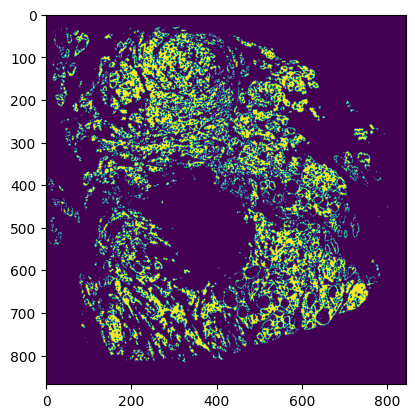

S18-9906-U3 multiplex_0 24


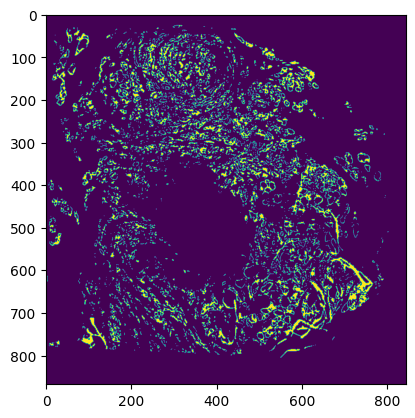

S18-9906-U5 batch2_he_0 3
S18-9906-U9 xenium_0 377


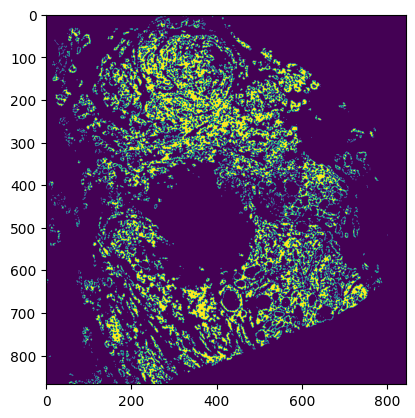

S18-9906-U10 multiplex_0 24


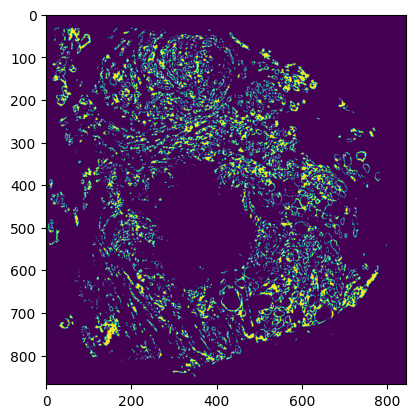

S18-9906-U12 batch2_he_0 3
S18-9906-U16 visium_0 17943
S18-9906-U17 xenium_0 377


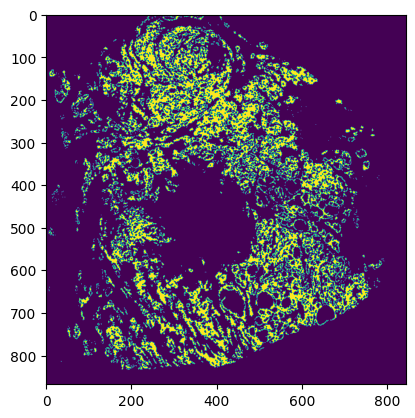

S18-9906-U18 multiplex_0 24


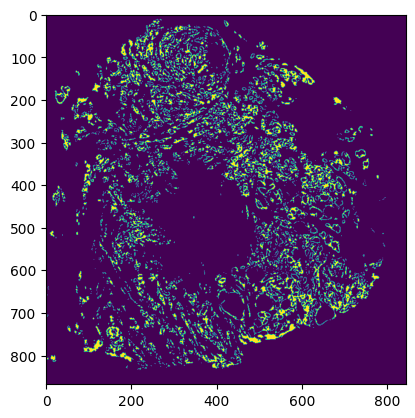

S18-9906-U20 batch2_he_0 3
S18-9906-U24 xenium_0 377


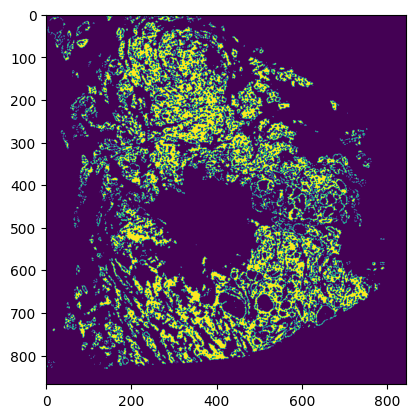

S18-9906-U25 multiplex_0 24


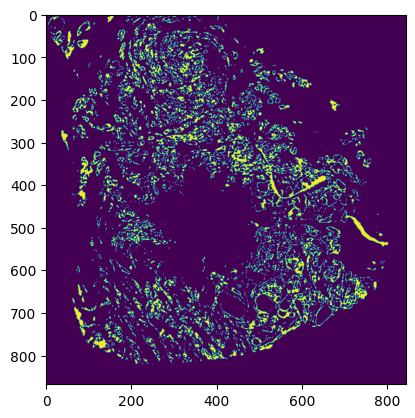

In [381]:
for case in case_order:
    print(case)
    imaris_dir = project_dir / case / 'imaris' / 'rois'
    config = yaml.safe_load(open(project_dir / case / 'registered' / 'metadata.yaml'))
    config = alter_filesystem(config, source_root, target_root)
    
    meta = json.load(open(imaris_dir / 'tiled' / 'metadata.json'))
    
    sid_to_channels = meta['sid_to_channels']
    dtype_ident_to_dtype = meta['dtype_ident_to_dtype']
    dtype_ident_to_channels = meta['dtype_ident_to_channels']
    sid_to_dtype_ident = meta['sid_to_dtype_ident']
    tiling_size = meta['tiling_size']
    size = meta['size']
    fullres_size = meta['fullres_size']
    dtype_ident_to_tiled_fps = meta['dtype_ident_to_tiled_fps']
    
    dtype_ident_to_tiled = {dti:tifffile.imread(fp) for dti, fp in dtype_ident_to_tiled_fps.items()}
    for dti, tiled in dtype_ident_to_tiled.items():
        print(dti, tiled.shape)
    
    sid_to_tiled_idx = {}
    for dtype_ident in dtype_ident_to_channels.keys():
        if 'vis' not in dtype_ident:
            dtype = dtype_ident_to_dtype[dtype_ident]
            sids = [entry['sid'] for entry in config['sections'] if sid_to_dtype_ident[entry['sid']]==dtype_ident]
            for i, sid in enumerate(sids):
                sid_to_tiled_idx[sid] = i

    meta_ct = json.load(open(imaris_dir / 'tiled_cell_types' / 'metadata.json'))

    sid_to_channels_ct = meta_ct['sid_to_channels']
    dtype_ident_to_dtype_ct = meta_ct['dtype_ident_to_dtype']
    dtype_ident_to_channels_ct = meta_ct['dtype_ident_to_channels']
    sid_to_dtype_ident_ct = meta_ct['sid_to_dtype_ident']
    dtype_ident_to_tiled_fps_ct = meta_ct['dtype_ident_to_tiled_fps']
    
    dtype_ident_to_tiled_ct = {dti:tifffile.imread(fp) for dti, fp in dtype_ident_to_tiled_fps_ct.items()}
    for dti, tiled in dtype_ident_to_tiled_ct.items():
        print(dti, tiled.shape)
    
    sid_to_tiled_idx_ct = {}
    for dtype_ident in dtype_ident_to_channels_ct.keys():
        dtype = dtype_ident_to_dtype_ct[dtype_ident]
        sids = [entry['sid'] for entry in config['sections'] if sid_to_dtype_ident.get(entry['sid'])==dtype_ident]
        for i, sid in enumerate(sids):
            sid_to_tiled_idx_ct[sid] = i

    data = pickle.load(
        open(project_dir / case / 'mushroom_50res' / f'outputs.pkl', 'rb')
    )
    mushroom_config = yaml.safe_load(
        open(project_dir / case / 'mushroom_50res' / f'config.yaml', 'rb')
    )
    mushroom_res = mushroom_config['trainer_kwargs']['target_resolution']

    for entry in config['sections']:
        sid = entry['sid']
        position = entry['position']
        dti = sid_to_dtype_ident[sid]
        dtype = dti.split('_')[0]
        channels = dtype_ident_to_channels[dti]
        fill_holes = True if case_to_disease[case] in ['brca'] else False
        print(sid, dti, len(channels))

        tups = [x for x in data['section_ids'] if x[1] == dtype]
        if (sid, dtype) in tups:
            idx = tups.index((sid, dtype))
            nbhds = data['dtype_to_clusters'][dtype][-1][idx].copy()
            nbhds = utils.rescale(nbhds, size=size, dim_order='h w', target_dtype=nbhds.dtype, antialias=False, interpolation=TF.InterpolationMode.NEAREST)
            nbhd_hots = rearrange(torch.nn.functional.one_hot(torch.tensor(nbhds)).numpy(), 'h w c -> c h w')
            nbhd_order = [f'nbhd{x}' for x in np.arange(nbhds.max() + 1)]
        else:
            nbhds, nbhd_hots, nbhd_order = None, None, None

        if dtype == 'multiplex':
            channels = [alter_name(x) for x in channels]

        if dti in dtype_ident_to_tiled and 'he_' not in dti and 'he_' not in dti:
            img = dtype_ident_to_tiled[dti][sid_to_tiled_idx[sid]]
            channel, cut = case_to_channel_info[case][dti]['epithelial']

            labeled = generate_labeled_regions(img[channels.index(channel)], cut, fill_holes=fill_holes)
            channel_info = case_to_channel_info[case][dti]

            inner = shrink_labels(labeled, distance=1)

            expanded = skimage.segmentation.expand_labels(labeled, distance=2)
            m = (expanded > 0) & ~(inner > 0)
            ring = expanded.copy()
            ring[~m] = 0
            
            expanded = skimage.segmentation.expand_labels(labeled, distance=10)
            m = (expanded > 0) & ~(skimage.segmentation.expand_labels(labeled, distance=2) > 0)
            tme = expanded.copy()
            tme[~m] = 0
            
            annot_to_mask = {
                k: img[channels.index(info[0])] > info[1] for k, info in channel_info.items()
            }
            
            stack = []
            for name, x in zip(['region', 'boundary', 'tme'], [inner, ring, tme]):
                df = get_feature_df(x, img, channels, channel_info)
                df.columns = [f'{name}_{c}' for c in df.columns]
                stack.append(df)

                if sid in sid_to_tiled_idx_ct:
                    ct_dti = sid_to_dtype_ident_ct[sid]
                    ct_img = dtype_ident_to_tiled_ct[ct_dti][sid_to_tiled_idx_ct[sid]]
                    ct_channels = dtype_ident_to_channels_ct[dti]
                    df = get_feature_df(x, ct_img, ct_channels, {})
                    df.columns = [f'{name}_celltypes_{c}' for c in df.columns]
                    stack.append(df)

                if nbhds is not None:
                    df = get_feature_df(x, nbhd_hots, nbhd_order, {})
                    df.columns = [f'{name}_neighborhoods_{c}' for c in df.columns]
                    stack.append(df)

            df = pd.concat(stack, axis=1)
        elif dti == 'vishd_0':
            fp = entry['data'][0]['filepath']
            adata = sc.read_h5ad(fp)
            adata.var_names_make_unique()
            adata.obs['y_location'] = adata.obs['y_location'] // 10
            adata.obs['x_location'] = adata.obs['x_location'] // 10
            pred_fp = project_dir / f'{case}' / 'multiplex_prediction' / 'predictions_vishd' / f'{sid}.ome.tif'
            pred_channels, dat = multiplex.extract_ome_tiff(pred_fp, as_dict=False)
            pred_channels = [alter_name(x) for x in pred_channels]
            channel, cut = case_to_channel_info[case]['vishd_multpred']['epithelial']
            img = dat[pred_channels.index(channel)]
            img = utils.rescale(img, size=size, dim_order='h w', target_dtype=img.dtype)
            
            labeled = generate_labeled_regions(img, cut, fill_holes=fill_holes)
            channel_info = case_to_channel_info[case][dti]

            inner = shrink_labels(labeled, distance=1)
            
            expanded = skimage.segmentation.expand_labels(labeled, distance=2)
            m = (expanded > 0) & ~(inner > 0)
            ring = expanded.copy()
            ring[~m] = 0
            
            expanded = skimage.segmentation.expand_labels(labeled, distance=10)
            m = (expanded > 0) & ~(skimage.segmentation.expand_labels(labeled, distance=2) > 0)
            tme = expanded.copy()
            tme[~m] = 0

            stack = []
            for name, x in zip(['region', 'boundary', 'tme'], [inner, ring, tme]):
                df = get_feature_df_vishd(x, adata)
                df.columns = [f'{name}_{c}' for c in df.columns]
                stack.append(df)

                if sid in sid_to_tiled_idx_ct:
                    ct_dti = sid_to_dtype_ident_ct[sid]
                    ct_img = dtype_ident_to_tiled_ct[ct_dti][sid_to_tiled_idx_ct[sid]]
                    ct_channels = dtype_ident_to_channels_ct[dti]
                    df = get_feature_df(x, ct_img, ct_channels, {})
                    df.columns = [f'{name}_celltypes_{c}' for c in df.columns]
                    stack.append(df)

                if nbhds is not None:
                    df = get_feature_df(x, nbhd_hots, nbhd_order, {})
                    df.columns = [f'{name}_neighborhoods_{c}' for c in df.columns]
                    stack.append(df)
                
            df = pd.concat(stack, axis=1)

        else:
            inner, ring, tme, df = None, None, None, None

        if inner is not None:
            plt.imshow(inner > 0)
            plt.show()
            tifffile.imwrite(output_dir / f'{sid}_regions.tif', inner, compression='LZW')
            tifffile.imwrite(output_dir / f'{sid}_boundaries.tif', ring, compression='LZW')
            tifffile.imwrite(output_dir / f'{sid}_tme.tif', tme, compression='LZW')
                
            df.to_csv(output_dir / f'{sid}_regions.txt.gz', sep='\t')
        

In [289]:
output_dir

PosixPath('/data/estorrs/mushroom/data/projects/submission_v1/analysis/region_characterization')

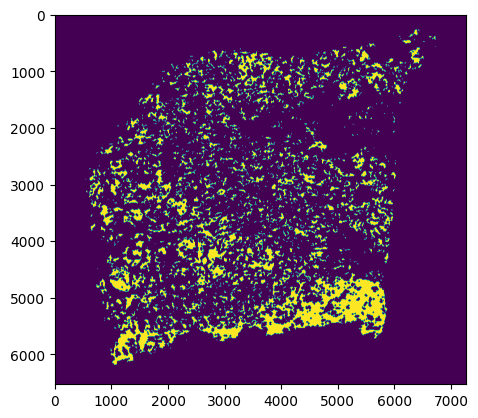

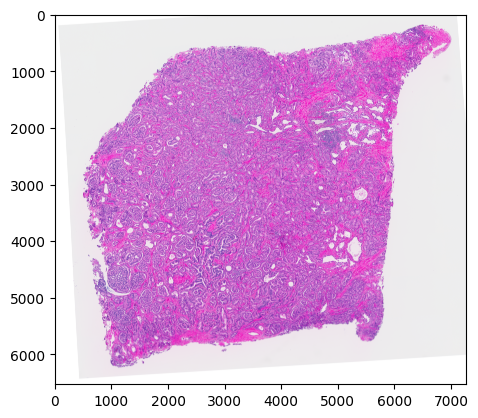

In [382]:
case = 'HT891Z1'
sid = 'HT891Z1-U2'
regions = tifffile.imread(output_dir / f'{sid}_regions.tif')
boundaries = tifffile.imread(output_dir / f'{sid}_boundaries.tif')
tmes = tifffile.imread(output_dir / f'{sid}_tme.tif')

rgb = tifffile.imread(project_dir / case / 'imaris' / 'rois' / 'full_rgbs' / f'{sid}.tif')

regions = utils.rescale(regions, size=rgb.shape[:2], dim_order='h w', target_dtype=regions.dtype, antialias=False, interpolation=TF.InterpolationMode.NEAREST)
boundaries = utils.rescale(boundaries, size=rgb.shape[:2], dim_order='h w', target_dtype=regions.dtype, antialias=False, interpolation=TF.InterpolationMode.NEAREST)
tmes = utils.rescale(tmes, size=rgb.shape[:2], dim_order='h w', target_dtype=regions.dtype, antialias=False, interpolation=TF.InterpolationMode.NEAREST)

plt.imshow(regions > 0)
plt.show()
plt.imshow(rgb)
plt.show()


In [115]:
arrs = [np.expand_dims(((x > 0) * 255).astype(np.uint8), -1) for x in [regions, boundaries, tmes]]
X = np.concatenate((rgb, *arrs), axis=-1).astype(np.uint8)
X = rearrange(X, 'h w c -> c h w')

multiplex.write_basic_ome_tiff(f'/data/estorrs/sandbox/{sid}.ome.tif', X, channels=['red', 'green', 'blue', 'region', 'boundary', 'tme'])

INFO:root:writting subres 2
INFO:root:subresolution shape: (3625, 4531)
INFO:root:writting subres 4
INFO:root:subresolution shape: (1812, 2265)
INFO:root:writting subres 8
INFO:root:subresolution shape: (906, 1132)
INFO:root:writting subres 16
INFO:root:subresolution shape: (453, 566)


In [116]:
def plot_overlays(arrs, rgb, titles=['region', 'boundary', 'tme'], figsize=None, bbox=None):
    if figsize is None:
        figsize = (5 * len(arrs), 10)

    if bbox is not None:
        r1, r2, c1, c2 = bbox
    else:
        bbox = 0, 0, arrs[0].shape[0], arrs[0].shape[1]
        

    fig, axs = plt.subplots(ncols=len(arrs), figsize=(20, 10))
    for x, ax, title in zip(arrs, axs, titles):
        labeled_img = x.copy()[r1:r2, c1:c2]
        rgb_img = rgb.copy()[r1:r2, c1:c2]
            
        m = skimage.segmentation.find_boundaries(labeled_img, mode='outer')
        for i in range(5):
            m = skimage.morphology.binary_dilation(m)
        rgb_img[m] = [255, 255, 0]
        ax.imshow(rgb_img)
        ax.set_title(title)
        ax.axis('off')

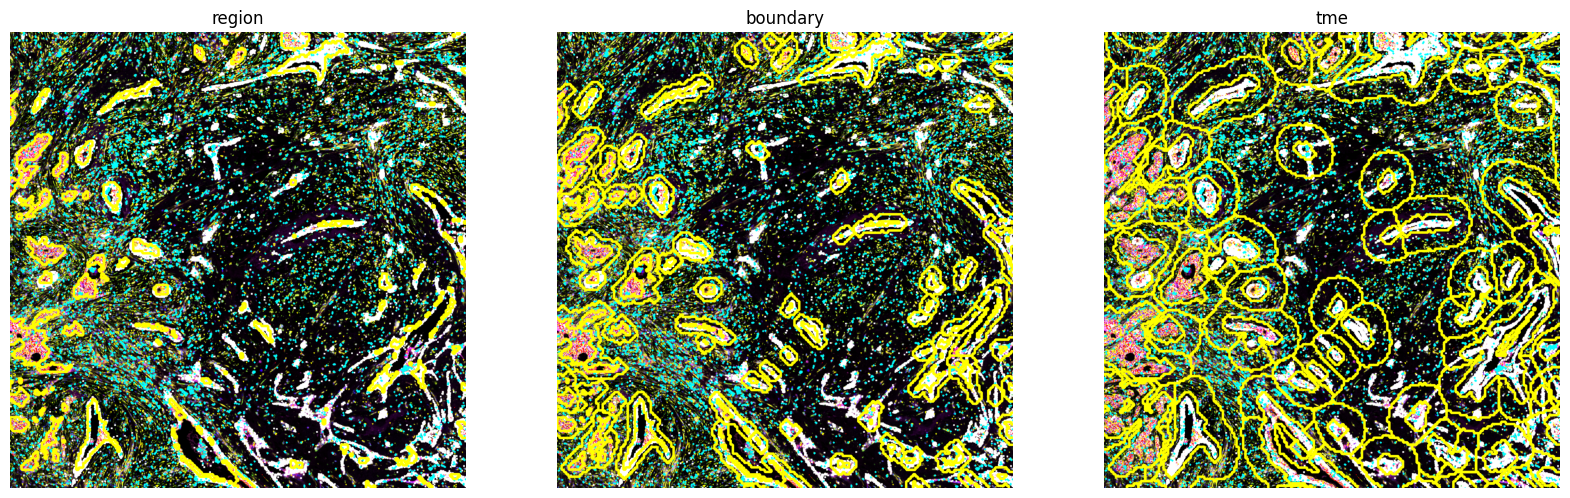

In [117]:
r1, r2, c1, c2 = 2000, 4000, 2000, 4000
plot_overlays([regions, boundaries, tmes], rgb, bbox=(r1, r2, c1, c2))

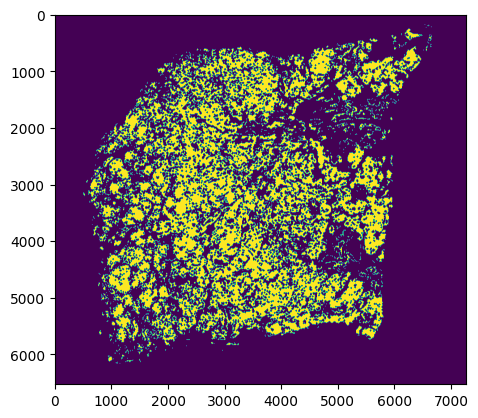

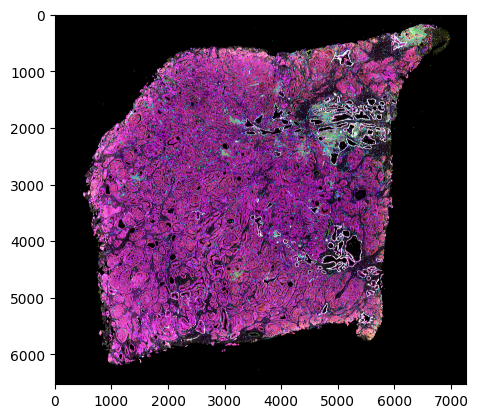

In [111]:
case = 'HT891Z1'
sid = 'HT891Z1-U1'
# sid = 'HT891Z1-U2'
regions = tifffile.imread(output_dir / f'{sid}_regions.tif')
boundaries = tifffile.imread(output_dir / f'{sid}_boundaries.tif')
tmes = tifffile.imread(output_dir / f'{sid}_tme.tif')

rgb = tifffile.imread(project_dir / case / 'imaris' / 'rois' / 'full_rgbs' / f'{sid}.tif')

regions = utils.rescale(regions, size=rgb.shape[:2], dim_order='h w', target_dtype=regions.dtype, antialias=False, interpolation=TF.InterpolationMode.NEAREST)
boundaries = utils.rescale(boundaries, size=rgb.shape[:2], dim_order='h w', target_dtype=regions.dtype, antialias=False, interpolation=TF.InterpolationMode.NEAREST)
tmes = utils.rescale(tmes, size=rgb.shape[:2], dim_order='h w', target_dtype=regions.dtype, antialias=False, interpolation=TF.InterpolationMode.NEAREST)

plt.imshow(regions > 0)
plt.show()
plt.imshow(rgb)
plt.show()


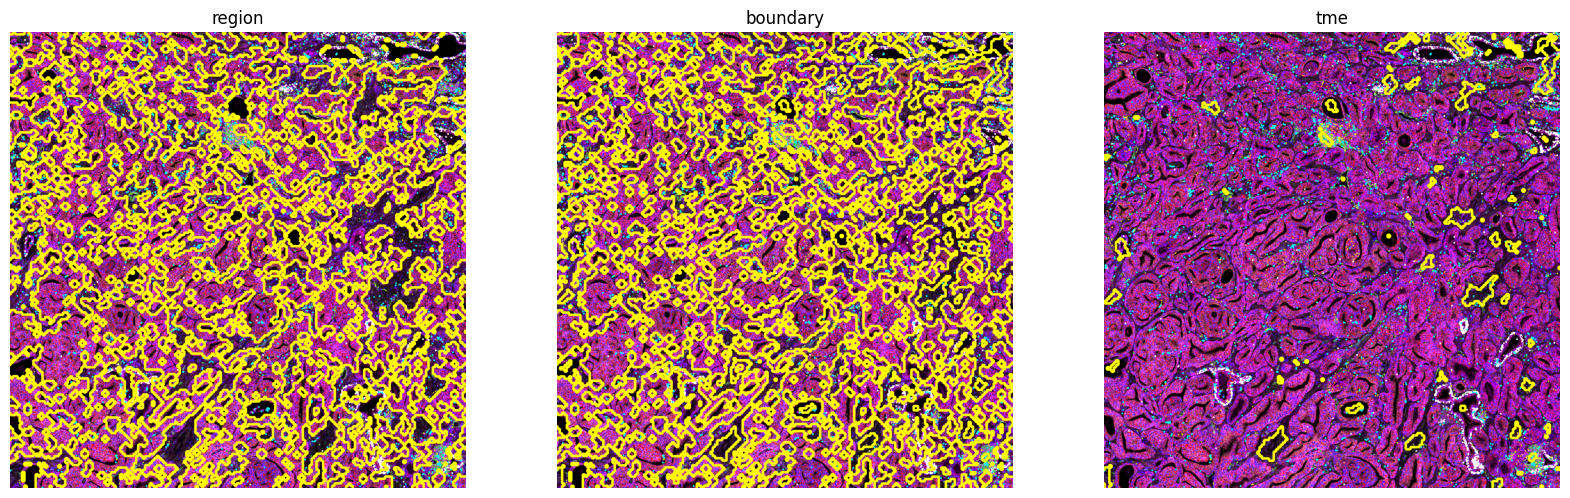

In [112]:
r1, r2, c1, c2 = 2000, 4000, 2000, 4000
plot_overlays([regions, boundaries, tmes], rgb, bbox=(r1, r2, c1, c2))

In [113]:
arrs = [np.expand_dims(((x > 0) * 255).astype(np.uint8), -1) for x in [regions, boundaries, tmes]]
X = np.concatenate((rgb, *arrs), axis=-1).astype(np.uint8)
X = rearrange(X, 'h w c -> c h w')

multiplex.write_basic_ome_tiff(f'/data/estorrs/sandbox/{sid}.ome.tif', X, channels=['red', 'green', 'blue', 'region', 'boundary', 'tme'])

INFO:root:writting subres 2
INFO:root:subresolution shape: (3265, 3629)
INFO:root:writting subres 4
INFO:root:subresolution shape: (1632, 1814)
INFO:root:writting subres 8
INFO:root:subresolution shape: (816, 907)
INFO:root:writting subres 16
INFO:root:subresolution shape: (408, 453)
